# 🚕 Predicting the Taxi Fare of New York City riders using Machine Learning

In this notebook, the goal is to predict the New York City Taxi Fare.

## 1. Problem

> How well can we predict the fare amount for a taxi ride in New York City, given the pickup and dropoff locations ?

**fare_amount** - float dollar amount of the cost of the taxi ride. This value is only in the training set and this is what we are predicting in the test set.

## 2. Data

The data is downloaded from the Kaggle New York City Taxi Fare Prediction competition:
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

There are two main datasets:
- **Train.csv**, the training set, which contains data from January 1, 2009 - June 30, 2015.
- **Test.csv**, the test set, which contains data from January 1, 2009 - June 30, 2015.

## 3. Evaluation

The evaluation metric for this competition is the **RMSE** (root mean-squared error) between the actual and predicted fare amount.

For more on the evaluation on this project check:
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

## 4. Features

* **pickup_datetime** - timestamp value indicating when the taxi ride started.
* **pickup_longitude** - float for longitude coordinate of where the taxi ride started.
* **pickup_latitude** - float for latitude coordinate of where the taxi ride started.
* **dropoff_longitude** - float for longitude coordinate of where the taxi ride ended.
* **dropoff_latitude** - float for latitude coordinate of where the taxi ride ended.
* **passenger_count** - integer indicating the number of passengers in the taxi ride.

In [81]:
# Standard imports
# Regular EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

# Models from Scikit-Learn
from sklearn.ensemble import RandomForestRegressor

# Model Evaluations

## Get the data

In [2]:
!kaggle competitions download -p datasets/new-york-city-taxi -c new-york-city-taxi-fare-prediction

100%|█████████████████████████████████████▉| 1.56G/1.56G [00:38<00:00, 42.6MB/s]
100%|██████████████████████████████████████| 1.56G/1.56G [00:38<00:00, 43.1MB/s]


In [3]:
!unzip datasets/new-york-city-taxi/new-york-city-taxi-fare-prediction.zip -d datasets/new-york-city-taxi

Archive:  datasets/new-york-city-taxi/new-york-city-taxi-fare-prediction.zip
  inflating: datasets/new-york-city-taxi/GCP-Coupons-Instructions.rtf  
  inflating: datasets/new-york-city-taxi/sample_submission.csv  
  inflating: datasets/new-york-city-taxi/test.csv  
  inflating: datasets/new-york-city-taxi/train.csv  


In [50]:
NB_ROWS = 400000

In [51]:
taxi = pd.read_csv("datasets/new-york-city-taxi/train.csv", nrows=NB_ROWS)
taxi.shape

(400000, 8)

## EDA

We will here try to find out more about the data.

In [13]:
taxi.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [52]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                400000 non-null  object 
 1   fare_amount        400000 non-null  float64
 2   pickup_datetime    400000 non-null  object 
 3   pickup_longitude   400000 non-null  float64
 4   pickup_latitude    400000 non-null  float64
 5   dropoff_longitude  399997 non-null  float64
 6   dropoff_latitude   399997 non-null  float64
 7   passenger_count    400000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 24.4+ MB


In [53]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,400000.000000,400000.000000,400000.000000,399997.000000,399997.000000,400000.000000
mean,11.363011,-72.512749,39.920196,-72.512494,39.919394,1.683415
std,9.944799,11.240633,8.356897,10.835233,6.498969,1.307503
min,-44.900000,-740.000000,-3116.285383,-1329.621332,-1189.615440,0.000000
25%,6.000000,-73.992055,40.734968,-73.991367,40.734072,1.000000
50%,8.500000,-73.981789,40.752727,-73.980105,40.753194,1.000000
75%,12.500000,-73.967090,40.767104,-73.963543,40.768115,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


Each row represents one race. There are 6 attributes: 
pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude and passenger_count.

We've chosen 20,000 instances in the dataset which is good to get started.

All attributes are numerical except pickup_datetime which is an object. As its name says it, it represents a date.

In [54]:
taxi.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    3
dropoff_latitude     3
passenger_count      0
dtype: int64

We notice that none of the attributes has null values except dropoff gps coordonates.

In [17]:
taxi.pickup_datetime[:10]

0    2009-06-15 17:26:21 UTC
1    2010-01-05 16:52:16 UTC
2    2011-08-18 00:35:00 UTC
3    2012-04-21 04:30:42 UTC
4    2010-03-09 07:51:00 UTC
5    2011-01-06 09:50:45 UTC
6    2012-11-20 20:35:00 UTC
7    2012-01-04 17:22:00 UTC
8    2012-12-03 13:10:00 UTC
9    2009-09-02 01:11:00 UTC
Name: pickup_datetime, dtype: object

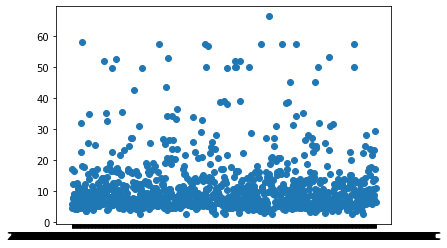

In [55]:
fig, ax = plt.subplots()
ax.scatter(taxi["pickup_datetime"][:1000], taxi["fare_amount"][:1000]);

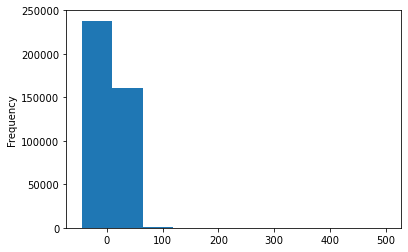

In [63]:
taxi.fare_amount.plot.hist();

In [57]:
taxi.passenger_count.value_counts()

1    276927
2     58995
5     28364
3     17403
4      8472
6      8422
0      1417
Name: passenger_count, dtype: int64

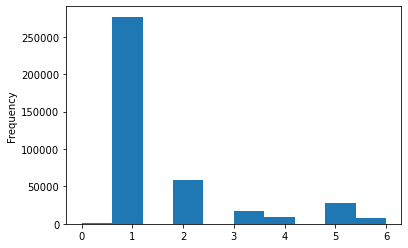

In [64]:
taxi.passenger_count.plot.hist();

### Visualizing Geographical Data

Since there is geographical information (latitude, longitude), we'll plot the data of all races.

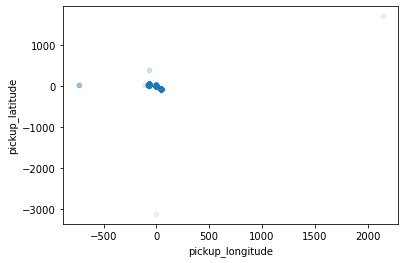

In [65]:
taxi.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude", alpha=0.1);

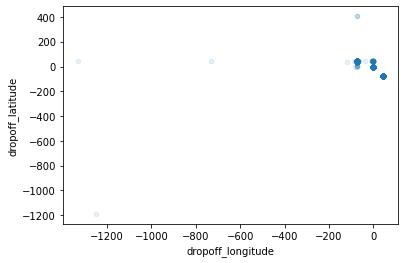

In [66]:
taxi.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude", alpha=0.1);

It seems that there is a lot of races in Spain.

### Parsing dates

As we are working with time series data, we want to enrich the time and date component as much as possible.

In [67]:
# We import the data again but we parse dates
taxi = pd.read_csv("datasets/new-york-city-taxi/train.csv", nrows=NB_ROWS,
                  low_memory=False,
                  parse_dates=["pickup_datetime"])

In [68]:
taxi.pickup_datetime.dtype

datetime64[ns, UTC]

In [69]:
taxi.pickup_datetime[:10]

0   2009-06-15 17:26:21+00:00
1   2010-01-05 16:52:16+00:00
2   2011-08-18 00:35:00+00:00
3   2012-04-21 04:30:42+00:00
4   2010-03-09 07:51:00+00:00
5   2011-01-06 09:50:45+00:00
6   2012-11-20 20:35:00+00:00
7   2012-01-04 17:22:00+00:00
8   2012-12-03 13:10:00+00:00
9   2009-09-02 01:11:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

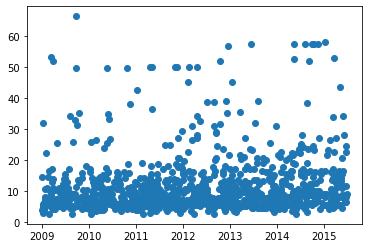

In [70]:
fig, ax = plt.subplots()
ax.scatter(taxi["pickup_datetime"][:1000], taxi["fare_amount"][:1000]);

In [71]:
taxi.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [72]:
taxi.head().T

,0,1,2,3,4
key,2009-06-15 17:26:21.0000001,2010-01-05 16:52:16.0000002,2011-08-18 00:35:00.00000049,2012-04-21 04:30:42.0000001,2010-03-09 07:51:00.000000135
fare_amount,4.500000,16.900000,5.700000,7.700000,5.300000
pickup_datetime,2009-06-15 17:26:21+00:00,2010-01-05 16:52:16+00:00,2011-08-18 00:35:00+00:00,2012-04-21 04:30:42+00:00,2010-03-09 07:51:00+00:00
pickup_longitude,-73.844311,-74.016048,-73.982738,-73.987130,-73.968095
pickup_latitude,40.721319,40.711303,40.761270,40.733143,40.768008
dropoff_longitude,-73.841610,-73.979268,-73.991242,-73.991567,-73.956655
dropoff_latitude,40.712278,40.782004,40.750562,40.758092,40.783762
passenger_count,1,1,2,1,1


In [73]:
# Sort DataFrame in date order
taxi.sort_values(by=["pickup_datetime"], inplace=True, ascending=True)
taxi.pickup_datetime.head(10)

297860   2009-01-01 00:31:32+00:00
124750   2009-01-01 00:35:03+00:00
82469    2009-01-01 00:41:00+00:00
124445   2009-01-01 00:47:26+00:00
76195    2009-01-01 01:21:54+00:00
102243   2009-01-01 01:22:54+00:00
12739    2009-01-01 01:31:49+00:00
307980   2009-01-01 01:55:56+00:00
17546    2009-01-01 02:05:37+00:00
25687    2009-01-01 02:07:49+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

### Copy of the original DataFrame
We make a copy of the original DataFrame so when we manipulate the copy, we've still got our original data.



In [74]:
taxi_tmp = taxi.copy()

In [75]:
# Add datetime parameters for pickup_datetime column
taxi[:1].pickup_datetime.dt.year

297860    2009
Name: pickup_datetime, dtype: int64

In [76]:
taxi[:1].pickup_datetime.dt.day

297860    1
Name: pickup_datetime, dtype: int64

In [77]:
taxi["pickupYear"] = taxi.pickup_datetime.dt.year
taxi["pickupMonth"] = taxi.pickup_datetime.dt.month
taxi["pickupDay"] = taxi.pickup_datetime.dt.day
taxi["pickupDayOfWeek"] = taxi.pickup_datetime.dt.dayofweek
taxi["pickupDayOfYear"] = taxi.pickup_datetime.dt.dayofyear

In [78]:
taxi.head().T

,297860,124750,82469,124445,76195
key,2009-01-01 00:31:32.0000001,2009-01-01 00:35:03.0000001,2009-01-01 00:41:00.0000003,2009-01-01 00:47:26.0000007,2009-01-01 01:21:54.0000002
fare_amount,11.800000,16.500000,6.200000,5.400000,4.900000
pickup_datetime,2009-01-01 00:31:32+00:00,2009-01-01 00:35:03+00:00,2009-01-01 00:41:00+00:00,2009-01-01 00:47:26+00:00,2009-01-01 01:21:54+00:00
pickup_longitude,-73.955075,-73.991938,-73.994202,-73.987324,-73.951810
pickup_latitude,40.768991,40.738414,40.751008,40.749571,40.714897
dropoff_longitude,-73.973230,-74.003499,-73.985817,-73.976034,-73.962162
dropoff_latitude,40.747979,40.683326,40.750577,40.741951,40.709354
passenger_count,1,1,2,1,4
pickupYear,2009,2009,2009,2009,2009
pickupMonth,1,1,1,1,1


In [79]:
taxi.drop("pickup_datetime", axis=1, inplace=True)

## 5. Modelling

We've done some EDA. Let's start to do some model-driven EDA.

In [82]:
# Build a machine learning model
model = RandomForestRegressor(n_jobs=1,
                             random_state=42)
model.fit(taxi.drop("fare_amount", axis=1), taxi["fare_amount"])

ValueError: could not convert string to float: '2009-01-01 00:31:32.0000001'